[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mohabmahdy/Indoor_air_quality/blob/main/Indoor_air_quality_hospital.ipynb)

## Install dependecies

In [ ]:
#%pip install casadi

## Import

In [1]:
#import casadi as ca
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def air_discrete_dynamics(p, lambda_, c_0, epsilon, v_d, A, V, c, T, get_derivative=False):
    dcdt = p*lambda_*c_0-lambda_*c+epsilon/V-v_d*A*c/V
    if get_derivative:
        return c+dcdt*T, dcdt
    return c+dcdt*T

    
def air_discrete_multi_input(p, lambda_, c_0, epsilon, v_d, A, V, c, T, get_derivative=False):
    n_inputs = len(lambda_)
    dcdt = 0
    for i in range(n_inputs):
        dcdt += p*lambda_[i]*c_0[i]-lambda_[i]*c
    dcdt += epsilon/V-v_d*A*c/V
    if get_derivative:
        return c+dcdt*T, dcdt
    return c+dcdt*T


In [35]:
# the class of the ventilation model simulator
class Hospital_Ventilation_Model:
    def __init__(self, adjacency_flow_rate:np.ndarray, control_factor:np.ndarray, n_pollutant:int = 3, sampling_time:float = 0.1):
        # the adjacency matrix of the hospital is a square matrix n*n representing the flow rate of air between different rooms
        # the diagonal elements are always set to zero
        # the off-diagonal elements are set to the ventilation rate of the rooms to which are connected, it is positive if the flow is coming inside from other rooms, otherwise zero
        # if A[i,j] > 0, it means that the flow is coming from room j to room i
        # the control factor is an n*m matrix which represents the effect of each input on each room, the sum of the elements of each column is equal to 1
        self.adjacency_flow_rate = adjacency_flow_rate
        self.control_factor = control_factor
        self.n_pollutant = n_pollutant
        self.sampling_time = sampling_time


        self.n_rooms = adjacency_flow_rate.shape[0]
        self.n_inputs = control_factor.shape[1]

        self.only_input_rooms = self.get_rooms_only_input()

        self.ordered_calculations = self.order_inputs()

        #self.model_states = np.array((self.n_pollutant, self.n_rooms))


    def get_rooms_only_input(self):
        input_rooms = []
        for i in range(self.n_rooms):
            if np.sum(self.adjacency_flow_rate[i,:]) == 0:
                input_rooms.append(i)
        return input_rooms
    

    def set_models_parameters(self, C0, V, epsilon, v_d, A, p, c_initial):
        self.C0 = C0                # Outdoor concentration of the pollutant
        self.V = V                  # Volume of the rooms
        self.epsilon = epsilon      # Emission rate of the pollutant
        self.v_d = v_d              # Deposition velocity of the pollutant
        self.A = A                  # Area of the rooms
        self.p = p                  # Penetration factor of the pollutant
        self.c_initial = c_initial  # Initial state
        self.check_paramters()

    
    def set_initial_state(self, c_initial):
        assert c_initial.any() >= 0, "The initial concentration of the pollutant should be positive"
        self.c_initial = c_initial
        self.check_paramters()


    def check_paramters(self):
        assert self.C0.shape[0] == self.n_pollutant, "The outdoor concentration of the pollutant should have the same number of elements as the number of pollutants"
        assert self.C0.any() >= 0, "The outdoor concentration of the pollutant should be positive"
        assert self.V.shape[0] == self.n_rooms, "The volume of the rooms should have the same number of elements as the number of rooms"
        assert self.V.any() > 0, "The volume of the rooms should be positive"
        assert self.epsilon.shape[0] == self.n_pollutant, "The emission rate of the pollutant should have the same number of elements as the number of pollutants"
        assert self.v_d.shape[0] == self.n_pollutant, "The deposition velocity of the pollutant should have the same number of elements as the number of pollutants"
        assert self.A.shape[0] == self.n_rooms, "The area of the rooms should have the same number of elements as the number of rooms"
        assert self.A.any() > 0, "The area of the rooms should be positive"
        assert self.p.shape[0] == self.n_pollutant, "The penetration factor of the pollutant should have the same number of elements as the number of pollutants"
        assert self.c_initial.shape == (self.n_pollutant,self.n_rooms), "The initial concentration of the pollutants should have the shape n_pollutant x n_rooms"

    def step(self, u):
        # u is the input to the system, it is the flow rate of the air to the rooms with independent flow rate
        # u should be a numpy array with the same number of elements as the number of rooms with independent flow rate
        assert u.shape[0] == self.n_inputs, "The input should have the same number of elements as the number of rooms with independent flow rate"
        self.check_paramters()
        new_state = np.zeros((self.n_pollutant, self.n_rooms))

        # the order of the calculations is important to calculate the concentration of the pollutants in each room
        # the order is given by self.ordered_calculations
        # the concentration of the pollutants in each room is calculated by the function air_discrete_multi_input

        air_flow_all_rooms = np.zeros(self.n_rooms+self.n_inputs)
        initial_value = np.zeros((self.n_pollutant, self.n_rooms+self.n_inputs))
        air_flow_all_rooms[self.n_rooms:] = u.copy()
        initial_value[:,:self.n_rooms] = self.c_initial.copy()
        initial_value[:,self.n_rooms:] = np.multiply(np.ones((self.n_inputs, self.n_pollutant)),self.C0).T
        

        # Calculate the concentration of the pollutant in each room
        for i in self.ordered_calculations:
            input_for_room = np.multiply(self.extended_dynamics[i,:], air_flow_all_rooms)
            for j in range(self.n_pollutant):
                new_state[j,i] = air_discrete_multi_input(self.p[j], np.divide(input_for_room,self.V[i]), initial_value[j,:], self.epsilon[j], self.v_d[j], self.A[i], self.V[i], self.c_initial[j,i], self.sampling_time)
                if new_state[j,i] < 0:
                    new_state[j,i] = 0
            air_flow_all_rooms[i] = np.sum(input_for_room)
        
        self.last_air_flow_all_rooms = air_flow_all_rooms
        self.c_initial = new_state
        return new_state
    

    

    def order_inputs(self):
        a = self.adjacency_flow_rate.copy()
        all_rooms = np.array(list(range(self.n_rooms)))
        order_of_calculations = []

        for i in self.only_input_rooms:
            all_rooms=np.setdiff1d(all_rooms,i)
            a[:,i] = np.zeros(self.n_rooms)
            order_of_calculations.append(i)

        while len(all_rooms) > 0: 
            prev_len = len(all_rooms)
            for i in all_rooms:
                # check if all the inputs of the room i are already calculated
                input_from = a[i,:]
                if np.sum(input_from)==0:
                    order_of_calculations.append(i)
                    a[:,i] = np.zeros(self.n_rooms)
                    all_rooms = np.setdiff1d(all_rooms,i)
            last_len = len(all_rooms)
            if prev_len == last_len:
                print("There is a cycle in the adjacency matrix")
                break
        
        # Organize the state with the inputs
        self.extended_dynamics = np.zeros((self.n_rooms+self.n_inputs, self.n_rooms+self.n_inputs))
        self.extended_dynamics[:self.n_rooms,:self.n_rooms] = self.adjacency_flow_rate.copy()
        self.extended_dynamics[:self.n_rooms, self.n_rooms:] = self.control_factor.copy()


        return order_of_calculations

    


In [28]:
def create_adj_matrix(edges, n_nodes):
    # The edges are a list of lists with the following structure
    # ['from', 'to', 'rate']
    # n_nodes is the number of nodes in the graph
    adj_matrix = np.zeros((n_nodes,n_nodes))
    for edge in edges:
        adj_matrix[edge[1],edge[0]] = edge[2]
    return adj_matrix

def create_control_matrix(connections, n_inputs, n_nodes):
    # The connections are a list of lists with the following structure
    # ['from', 'to', 'rate']
    # n_inputs is the number of inputs in the graph
    control_matrix = np.zeros((n_nodes,n_inputs))
    for connection in connections:
        control_matrix[connection[1],connection[0]] = connection[2]
    return control_matrix


In [36]:
n_rooms = 5
n_pollutants = 1
n_inputs = 3


edges = [   [0,1,0.1],
            [1,4,0.1],
            [2,4,0.1],
            [3,0,0.05],
            [3,1,0.1]   ]
control_connections = [ [0,0,0.4],
                        [0,3,0.2],
                        [0,2,0.4],
                        [1,1,0.5],
                        [1,3,0.5],
                        [2,2,0.5],
                        [2,3,0.4],
                        [2,4,0.1]   ]
A = create_adj_matrix(edges, n_rooms)
control_matrix = create_control_matrix(control_connections, n_inputs, n_rooms)

C0 = np.random.random((n_pollutants))
V = np.random.random((n_rooms))
epsilon = np.random.random((n_pollutants))
v_d = np.random.random((n_pollutants))
Area = np.random.random((n_rooms))
p = np.random.random((n_pollutants))
c_initial = np.random.random((n_pollutants,n_rooms))





hospital_model = Hospital_Ventilation_Model(A,control_matrix ,n_pollutant=n_pollutants)

# define parameters of the model





hospital_model.set_models_parameters(C0,V,epsilon,v_d,Area,p,c_initial)

#print(hospital_model.input_rooms)

In [44]:
time_steps = 100
all_states = np.zeros((time_steps, n_pollutants, n_rooms))
all_controls = np.zeros((time_steps, n_inputs))
all_states[0,:,:] = c_initial[:,:]

for i in range(1,time_steps):
    u = np.random.random((n_inputs))
    all_controls[i,:] = u
    all_states[i,:,:] = hospital_model.step(u)


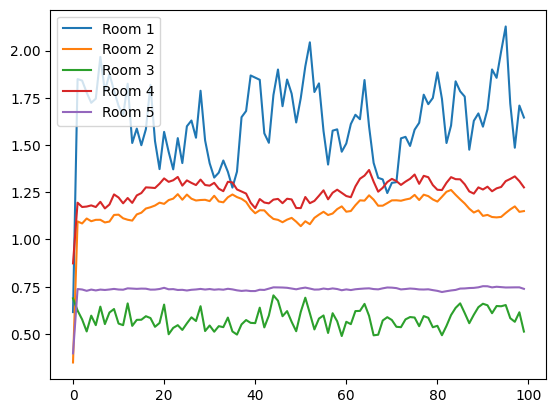

In [46]:
plt.plot(all_states[:,0,:], label=['Room '+str(i+1) for i in range(n_rooms)])
plt.legend()

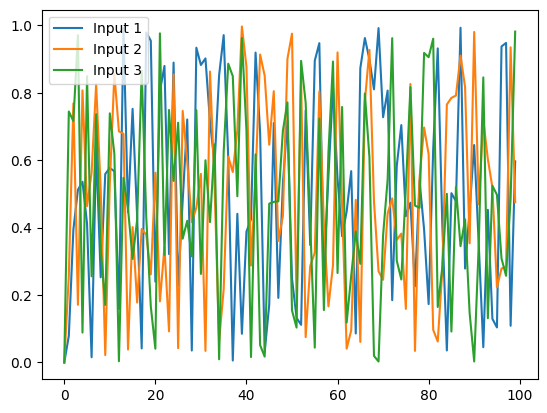

In [47]:
plt.plot(all_controls, label=['Input '+str(i+1) for i in range(n_inputs)])
plt.legend()